# Trabajo Práctico Nro. 2
## Machine Learning 2.
### Ejercicio 1.
Alumnos:
  - Crenna, Giuliano.
  - Sancho Almenar, Mariano.
  - Pace, Bruno.


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bpace1/ML-Redes-Densas-Convolucionales/blob/main/ej1_student_performance.ipynb)

# Configuración del entorno

In [29]:
# Standard library imports
import os
import pathlib
import urllib.request
import zipfile
import shutil
from pathlib import Path

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from IPython import display
import librosa

# TensorFlow specific imports
from tensorflow.keras import layers, models

# Set the seed value for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

# Carga y ADA del dataset

In [15]:
# Configuration
DATASET_URL: str = "https://github.com/Jakobovski/free-spoken-digit-dataset/archive/refs/heads/master.zip"
DATASET_PATH: str = 'data/spoken_digits'
RAW_DATA_PATH: str = os.path.join(DATASET_PATH, 'recordings')
ZIP_FILE: str = 'spoken_digits.zip'

# Create directory structure
data_dir = pathlib.Path(DATASET_PATH)
data_dir.mkdir(parents=True, exist_ok=True)

# Download dataset if not exists
if not os.path.exists(RAW_DATA_PATH):
    print("Downloading the Spoken Digit dataset...")
    urllib.request.urlretrieve(DATASET_URL, ZIP_FILE)

    # Extract the zip file
    with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
        zip_ref.extractall(DATASET_PATH)

    # Move recordings to the right place
    extracted_folder = os.path.join(DATASET_PATH, 'free-spoken-digit-dataset-master', 'recordings')
    shutil.move(extracted_folder, DATASET_PATH)

    # Clean up
    os.remove(ZIP_FILE)
    shutil.rmtree(os.path.join(DATASET_PATH, 'free-spoken-digit-dataset-master'))
    print("Download and extraction complete!")
else:
    print("Dataset already downloaded.")

Download and extraction complete!


In [17]:
def organize_fsdd_dataset(raw_data_path: str, organized_data_path: str) -> None:
    """Reorganize FSDD into class-based subdirectories"""

    # Create organized directory structure
    Path(organized_data_path).mkdir(parents=True, exist_ok=True)

    # Create subdirectories for each digit (0-9)
    for digit in range(10):
        os.makedirs(os.path.join(organized_data_path, str(digit)), exist_ok=True)

    # Move files to their respective class directories
    for file_path in Path(raw_data_path).glob('*.wav'):
        digit = file_path.name.split('_')[0]  # Extract digit from filename
        dest_path = os.path.join(organized_data_path, digit, file_path.name)
        shutil.move(str(file_path), dest_path)

    print(f"Dataset reorganized into class folders at: {organized_data_path}")

# Paths
RAW_DATA_PATH: str = 'data/spoken_digits/recordings'  # From previous download
ORGANIZED_DATA_PATH: str = 'data/spoken_digits_organized'

# Reorganize the dataset
organize_fsdd_dataset(RAW_DATA_PATH, ORGANIZED_DATA_PATH)

Dataset reorganized into class folders at: data/spoken_digits_organized


In [ ]:
# audio_structure = {
#     # ===== Dataset Metadata =====
#     "dataset": "Free Spoken Digit Dataset (FSDD)",
#     "source": "https://github.com/Jakobovski/free-spoken-digit-dataset",
#     "total_files": 3000,
#     "classes": ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
#     "class_distribution": "Balanced (300 samples per digit)",

#     # ===== Raw Audio Properties =====
#     "raw_audio": {
#         "sample_rate": "Original (varies by recording)",
#         "length_stats": {
#             "min_samples": 1148,       # ~0.14s at 8kHz
#             "max_samples": 18262,       # ~2.28s at 8kHz
#             "mean_samples": 3499,       # ~0.44s at 8kHz
#             "median_samples": 3358,     # ~0.42s at 8kHz
#             "95th_percentile": 5299     # ~0.66s at 8kHz
#         },
#         "normalization": "Not yet applied",
#         "file_structure": "WAV files named {digit}_{speaker}_{index}.wav"
#     },

#     # ===== Processed Audio Properties =====
#     "processed_audio": {
#         "sample_rate": 8000,            # 8kHz
#         "target_length": 8000,          # 1 second at 8kHz
#         "normalization": {
#             "type": "Automatic (tf.audio.decode_wav)",
#             "range": [-1.0, 1.0],
#             "observed_range": [-0.586, 0.495]  # Actual min/max in your data
#         },
#         "padding": {
#             "method": "Zero-padding",
#             "position": "End-padded",
#             "truncation": "Start-truncated (for clips >8000 samples)"
#         },
#         "final_shape": {
#             "training_batch": "(32, 8000, 1)",  # (batch, samples, channels)
#             "validation_batch": "(32, 8000, 1)",
#             "element_spec": {
#                 "audio": "TensorSpec(shape=(None, 8000, None), dtype=tf.float32)",
#                 "labels": "TensorSpec(shape=(None, 10), dtype=tf.float32)"
#             }
#         }
#     },

#     # ===== Pipeline Details =====
#     "processing_steps": [
#         "1. Download from GitHub",
#         "2. Organize into class folders (0-9)",
#         "3. Load with audio_dataset_from_directory",
#         "4. Automatic resampling to 8kHz",
#         "5. Normalization to [-1, 1]",
#         "6. Padding/truncation to 8000 samples",
#         "7. One-hot label encoding"
#     ],

#     # ===== Key Observations =====
#     "notes": [
#         "Original recordings vary significantly in length (0.14s-2.28s)",
#         "95% of clips fit within 0.66s (5299 samples at 8kHz)",
#         "Target length of 1s (8000 samples) provides buffer room",
#         "Batch shape confirms proper processing: (batch, time_steps, channels)"
#     ]
# }

In [33]:
def analyze_sequence_lengths(data_path: str) -> dict[str, int]:
    """Analyze raw audio lengths (in samples) across all class folders"""
    sequence_lengths = []

    # Find all WAV files recursively in class subdirectories
    wav_files = list(Path(data_path).rglob('*.wav'))

    if not wav_files:
        raise ValueError(f"No WAV files found in {data_path}")

    for file_path in wav_files:
        try:
            audio, _ = librosa.load(file_path, sr=None)  # Keep original sample rate
            sequence_lengths.append(len(audio))
        except Exception as e:
            print(f"Skipping {file_path.name}: {str(e)}")
            continue

    if not sequence_lengths:
        raise ValueError("No valid audio files processed")

    stats = {
        'min_samples': int(np.min(sequence_lengths)),
        'max_samples': int(np.max(sequence_lengths)),
        'mean_samples': int(np.mean(sequence_lengths)),
        'median_samples': int(np.median(sequence_lengths)),
        '95th_percentile': int(np.percentile(sequence_lengths, 95)),
        'total_files': len(sequence_lengths)
    }

    print("\nAudio Sequence Length (Samples)")
    print("-----------------------------")
    print(f"• Minimum: {stats['min_samples']:,} samples")
    print(f"• Maximum: {stats['max_samples']:,} samples")
    print(f"• Mean: {stats['mean_samples']:,} samples")
    print(f"• Median: {stats['median_samples']:,} samples")
    print(f"• 95th Percentile: {stats['95th_percentile']:,} samples")
    print(f"\nTotal files analyzed: {stats['total_files']}")
    return stats

# Analyze your dataset
stats = analyze_sequence_lengths('data/spoken_digits_organized')

stats['median_samples']


Audio Sequence Length (Samples)
-----------------------------
• Minimum: 1,148 samples
• Maximum: 18,262 samples
• Mean: 3,499 samples
• Median: 3,358 samples
• 95th Percentile: 5,299 samples

Total files analyzed: 3000


3358

In [53]:
# Parameters
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
SEED = 42
SEQUENCE_LENGTH = stats['median_samples']

# Create datasets
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=ORGANIZED_DATA_PATH,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    seed=SEED,
    output_sequence_length=SEQUENCE_LENGTH,
    subset='both',
    #labels='inferred',
    #label_mode='categorical'
)

# Get class names
label_names = np.array(train_ds.class_names)
print("\nLabel names:", label_names)

# Preview the dataset
print("\nDataset structure:")
for audio_batch, label_batch in train_ds.take(1):
    print("Audio batch shape:", audio_batch.shape)
    print("Label batch shape:", label_batch.shape)
    print("First label:", label_batch[0].numpy())

Found 3000 files belonging to 10 classes.
Using 2400 files for training.
Using 600 files for validation.

Label names: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']

Dataset structure:
Audio batch shape: (32, 3358, 1)
Label batch shape: (32,)
First label: 4


In [55]:
train_ds.element_spec

(TensorSpec(shape=(None, 3358, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [56]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [59]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(32, 3358)
(32,)


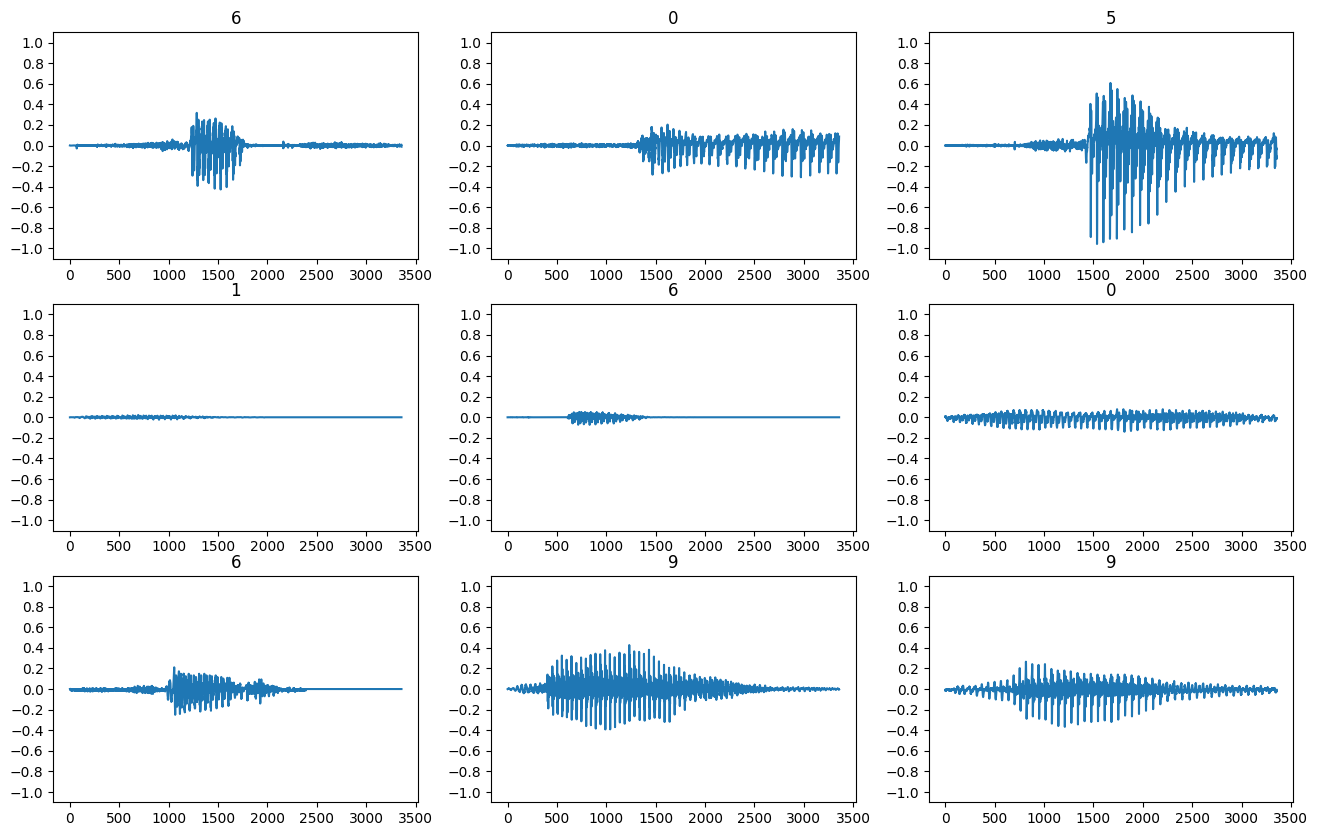

In [58]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [60]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [61]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: 9
Waveform shape: (3358,)
Spectrogram shape: (25, 129, 1)
Audio playback


Label: 2
Waveform shape: (3358,)
Spectrogram shape: (25, 129, 1)
Audio playback


Label: 7
Waveform shape: (3358,)
Spectrogram shape: (25, 129, 1)
Audio playback


In [62]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

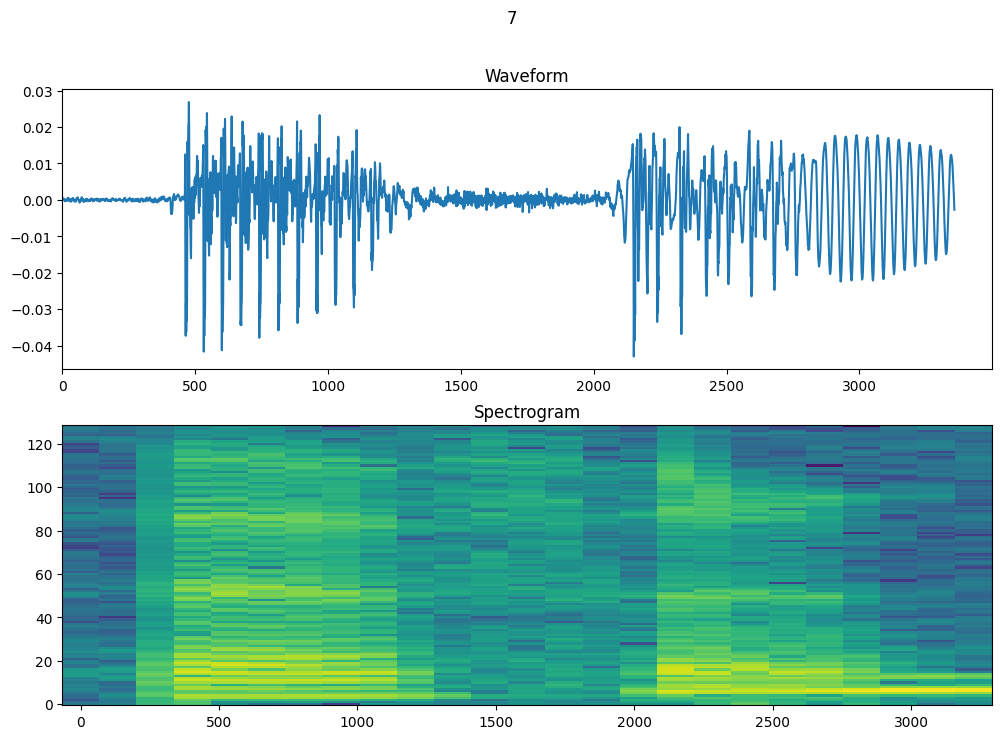

In [64]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, stats['mean_samples']])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [65]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [66]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)

In [68]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

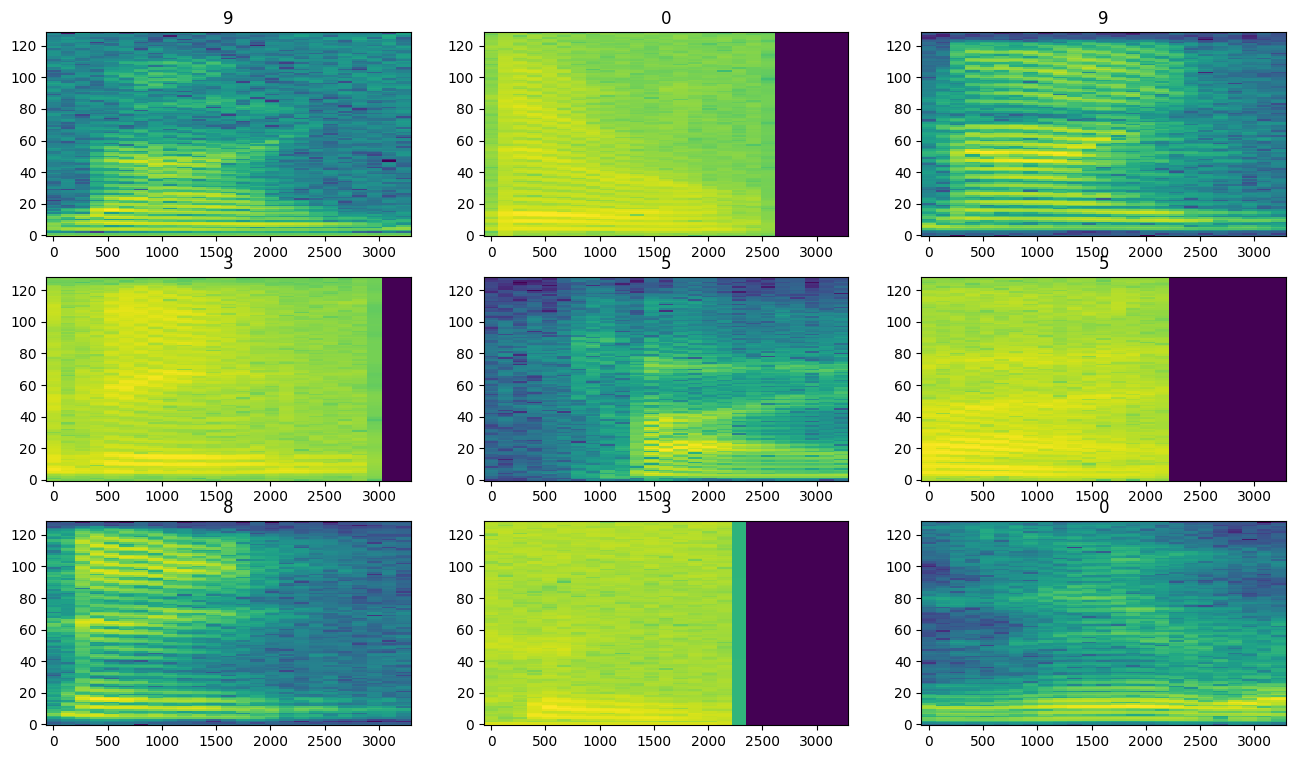

In [69]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [70]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [71]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (25, 129, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,869 (6.20 MB)

 Trainable params: 1,625,866 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

In [72]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [73]:
EPOCHS = 50
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.3422 - loss: 1.8709 - val_accuracy: 0.7300 - val_loss: 0.9433
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.6852 - loss: 0.9977 - val_accuracy: 0.8483 - val_loss: 0.5340
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.7768 - loss: 0.6086 - val_accuracy: 0.8967 - val_loss: 0.3561
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.8662 - loss: 0.4239 - val_accuracy: 0.9317 - val_loss: 0.2527
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.8917 - loss: 0.3165 - val_accuracy: 0.9433 - val_loss: 0.2181
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.9075 - loss: 0.2670 - val_accuracy: 0.9400 - val_loss: 0.2139
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.9169 - loss: 0.2552 - val_accuracy: 0.9467 - val_loss: 0.1816
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.9365 - loss: 0.1804 - val_accuracy: 0.9483 - 